In [1]:
import numpy as np
import scipy as sp

import skimage.io
import skimage.measure
import skimage.color

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

#Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['image.cmap'] = 'gray'
titlesize = 24
import sys, os

import SimpleITK as sitk
import nrrd


from scipy import ndimage
import pandas as pd
from radiomics import featureextractor
import joblib
from PIL import Image, ImageDraw
import cv2
import six

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import geojson
from PIL import Image, ImageDraw

import cv2
from json import JSONDecodeError

import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as ndi

from skimage import (
    color, feature, filters, measure, morphology, segmentation, util)
from scipy.stats import bartlett


In [2]:
import logging
# set level for all classes
logger = logging.getLogger("radiomics")
logger.setLevel(logging.ERROR)
# ... or set level for specific class
logger = logging.getLogger("radiomics.glcm")
logger.setLevel(logging.ERROR)

In [2]:
PATH = "/media/user/Watson/data_Lyon/Ovaires/1_c_patches_after_cleaning/"
PATH_json = '/media/user/Watson/data_Lyon/Ovaires/3_hovernet/'
# PATH_histo = "/media/user/Blake/PCNSL_2024/4_pyradiomics_patches/"
# #PATH_output_mask_nuclei = "/media/user/Ligue_RNA_2partie/PCNSL_2022/masks_nuclei_pyradiomics/"
PATH_output_mask_nuclei = "/media/user/Watson/data_Lyon/Ovaires/4_masks_nuclei_pyradiomics/"

PATH_df_pyradiomics = "/media/user/Watson/data_Lyon/Ovaires/4_df_pyradiomics/"
PATH_df_count_cells = '/media/user/Watson/data_Lyon/Ovaires/1_df_count_cells/'

In [3]:
#on enlève les bords et on garde diametre entre 8 3.2 et 21
width = 224
marge = 1
res = 0.23

nbre_pix_inf = 32
nbre_pix_sup = 350

In [4]:
from PIL import Image, ImageDraw
def function_cell(cell) :
    width = 224
    poly_cell = []
    for x in cell["contour"] :
        poly_cell.append((x[0], x[1]))
    width = width
    height = width
    
    mask_cell = np.zeros((width, width), dtype = int)
    
    img = Image.new('L', (width, height), 0)
    ImageDraw.Draw(img).polygon(poly_cell, outline = 1, fill=1)
    mask = np.array(img)
    mask_cell += mask
    
    mask_cell = np.array(mask_cell, dtype = 'uint8')

    
    return mask_cell

In [5]:
patients = os.listdir(PATH)
len(patients)

28

In [6]:
def nbre_pixels(cnt1):
    mask_cell = function_cell(cnt1)
    number_of_white_pix = np.sum(mask_cell != 0)
    return number_of_white_pix

In [7]:
list_excluded_keys = ['diagnostics_Versions_PyRadiomics',
 'diagnostics_Versions_Numpy',
 'diagnostics_Versions_SimpleITK',
 'diagnostics_Versions_PyWavelet',
 'diagnostics_Versions_Python',
 'diagnostics_Configuration_Settings',
 'diagnostics_Configuration_EnabledImageTypes',
 'diagnostics_Image-original_Hash',
 'diagnostics_Image-original_Dimensionality',
 'diagnostics_Image-original_Spacing',
 'diagnostics_Image-original_Size',
 'diagnostics_Image-original_Mean',
 'diagnostics_Image-original_Minimum',
 'diagnostics_Image-original_Maximum',
 'diagnostics_Mask-original_Hash',
 'diagnostics_Mask-original_Spacing',
 'diagnostics_Mask-original_Size',
 'diagnostics_Mask-original_BoundingBox',
 'diagnostics_Mask-original_VoxelNum',
 'diagnostics_Mask-original_VolumeNum',
 'diagnostics_Mask-original_CenterOfMassIndex',
 'diagnostics_Mask-original_CenterOfMass']

In [1]:
df_spl = pd.DataFrame()
count = 0
for patient in patients :
    print(patient)
    print('len df tot', len(df_spl))
    if not os.path.exists(PATH_df_pyradiomics+patient+".csv") :
        df =pd.DataFrame()# so_spl[so_spl['ID_patient']==patient]
        df_counts = pd.read_csv(PATH_df_count_cells+patient+'.csv')
        df_counts = df_counts.sort_values(by=['cells_filtre_tot'], ascending = False)
        patchs_file = []
        count_cells = 0
        for i in range(len(df_counts)) :
            if count_cells < 5000 :
                patchs_file.append(df_counts.iloc[i]['patch'])
                count_cells += df_counts.iloc[i]['cells_filtre_tot']

        patchs = []
       # patchs_file = list(df_counts['patch'])
        for i in patchs_file :
            patchs.append(i[:-5])#.split('/')[1])
        print(len(patchs))
        for patch in patchs :
            df_spl_temp = pd.DataFrame({'patient':[patient], 'patch':[patch]})
            df_spl = pd.concat([df_spl, df_spl_temp])
            input_image_file = np.asarray(Image.open(PATH+patient+"/"+patch+".jpg"))[:,:,0]
            with open(PATH_json+patient+'/json/'+patch+'.json') as f :
                nuclei = geojson.load(f)

            key_keep = []
            key_not_keep_bords = []
            key_not_keep_diametre = []
            key_not_keep = []


            for key in list(nuclei['nuc'].keys()) :
                for x in nuclei['nuc'][key]['contour'] :
                    if x[0] < marge or x[0] >= (width-marge) or x[1] < marge or x[1] >= (width-marge) :
                        key_not_keep_bords.append(key)     
                    pix_count = nbre_pixels(nuclei['nuc'][key])

                    if pix_count < nbre_pix_inf or pix_count > nbre_pix_sup : #
                        key_not_keep_diametre.append(key)

                    key_not_keep_bords = list(set(key_not_keep_bords))
                    key_not_keep_diametre = list(set(key_not_keep_diametre))
                    key_not_keep = key_not_keep_bords + key_not_keep_diametre
                    key_not_keep = list(set(key_not_keep))

                for x in nuclei['nuc'][key]['contour'] :
                    if key not in key_not_keep and key not in key_keep :
                        key_keep.append(key) 

            for key in key_keep :
                #print(key)
                mask_cellmasks = function_cell(nuclei['nuc'][key])
                if not os.path.exists(PATH_output_mask_nuclei+patient) :
                    os.makedirs(PATH_output_mask_nuclei+patient)
                nrrd.write(PATH_output_mask_nuclei+patient+"/"+patch+"__mask.nrrd", mask_cellmasks)
                nrrd.write(PATH_output_mask_nuclei+patient+"/"+patch+"__img.nrrd", input_image_file)
                settings = {'binWidth': 25,
                    'interpolator': sitk.sitkBSpline,
                    'resampledPixelSpacing': None,
                    'force2D': False,
                    'force2Ddimension': 0}
                imageType = {'Original': {}, 'Wavelet' : {}, 'LoG':None,'Square' : None, 'SquareRoot' : None, 'Logarithm' : None,'Exponential': None, 'Gradient': None,'LocalBinaryPattern2D':None, 'LocalBinaryPattern3D' : None}

             #   imageType = {'Original': {}, 'Wavelet' : {}, 'LoG':None,'Square' : None, 'SquareRoot' : None, 'Logarithm' : None,'Exponential': None, 'Gradient': None,'LocalBinaryPattern2D':None, 'LocalBinaryPattern3D' : None}

                extractor = featureextractor.RadiomicsFeatureExtractor() #**settings)#, **imageType)
                extractor.enableImageTypeByName('Wavelet')
                #extractor.enableImageTypeByName('LocalBinaryPattern2D')
               # extractor.enableFeatureClassByName('shape')
                extractor.enableFeatureClassByName('shape2D')

                try :
                    result = extractor.execute(PATH_output_mask_nuclei+patient+"/"+patch+"__img.nrrd",PATH_output_mask_nuclei+patient+"/"+patch+"__mask.nrrd")

                except RuntimeError :
                    print('erreur', patch)
                    continue
                features_names = {'ID_patient' : patient, 'patch' : patch, 'key' : key}

                for key, val in six.iteritems(result) :
                    if key in list_excluded_keys :
                        pass
                    else :
                        features_names[key] = val
                df_temp = pd.DataFrame.from_dict(data=features_names, orient='index')

                df = pd.concat([df, df_temp.T])
                #print(len(list(df.columns)))
                if len(df)%1000==0:
                    print('len df temp', len(df))
        print(len(df))
        df.to_csv(PATH_df_pyradiomics+patient+".csv")
        print('stocké')
    else:
        print('déja calculé')
    count += 1
    print('count', count)

# Heatmaps 

In [9]:
PATH_df_pyradiomics = '/media/user/Watson/data_Lyon/Ovaires/4_Athena/4_df_pyradiomics/'


In [9]:
patients_ctr = []
patients_yo = []
for patient in patients :
    if "CTR" in patient :
        patients_ctr.append(patient)
    else :
        patients_yo.append(patient)
print(len(patients_ctr))
print(len(patients_yo))

9
19


In [20]:
df_ctr = pd.DataFrame()
df_yo = pd.DataFrame()
#df_tot = pd.DataFrame()

for patient in patients :
    df = pd.read_csv(PATH_df_pyradiomics+patient+".csv")
    if patient in patients_ctr :
        df_ctr = pd.concat([df_ctr, df])
    else :
        df_yo = pd.concat([df_yo, df])
    #df_tot = pd.concat([df_tot, df])

In [12]:
df_ctr_means = df_ctr.drop(columns=['Unnamed: 0','ID_patient', 'patch', 'key'])
df_ctr_means.loc['ctr'] = df_ctr_means.mean()
df_ctr_means = pd.DataFrame(df_ctr_means.loc['ctr']).T

df_yo_means = df_yo.drop(columns=['Unnamed: 0','ID_patient', 'patch', 'key'])
df_yo_means.loc['yo'] = df_yo_means.mean()
df_yo_means = pd.DataFrame(df_yo_means.loc['yo']).T

In [18]:
df_tot_means = pd.DataFrame()

for patient in patients_ctr +  patients_yo :
   # print(patient)
    df_temp = pd.DataFrame(df_tot[df_tot['ID_patient'] == patient].drop(columns='status').median()).T
  #  df_temp = df_temp.T
    if 'CTR' in patient :
        statut = 'CTR'
    else :
        statut = 'YO'
    df_temp['status'] = statut
    df_temp['patient'] = patient
    df_tot_means = pd.concat([df_tot_means, df_temp])
df_tot_means.reset_index(inplace=True)


/tmp/ipykernel_7455/124596276.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_temp = pd.DataFrame(df_tot[df_tot['ID_patient'] == patient].drop(columns='status').median()).T
/tmp/ipykernel_7455/124596276.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_temp = pd.DataFrame(df_tot[df_tot['ID_patient'] == patient].drop(columns='status').median()).T
/tmp/ipykernel_7455/124596276.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_temp = pd.DataFrame(df_tot[df_tot['ID_patient

/tmp/ipykernel_7455/124596276.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_temp = pd.DataFrame(df_tot[df_tot['ID_patient'] == patient].drop(columns='status').median()).T
/tmp/ipykernel_7455/124596276.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_temp = pd.DataFrame(df_tot[df_tot['ID_patient'] == patient].drop(columns='status').median()).T
/tmp/ipykernel_7455/124596276.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_temp = pd.DataFrame(df_tot[df_tot['ID_patient

In [29]:
df_tot_means_zscore = pd.DataFrame()

for i in list(df_tot_means.columns) :
    if i not in ['Unnamed: 0','ID_patient', 'patch', 'key', 'status', 'patient'] :
        df_tot_means_zscore[i] = (df_tot_means[i] - df_tot_means[i].mean())/(df_tot_means[i].std(ddof=0))
    

/tmp/ipykernel_1398959/3914422978.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_tot_means_zscore[i] = (df_tot_means[i] - df_tot_means[i].mean())/(df_tot_means[i].std(ddof=0))
/tmp/ipykernel_1398959/3914422978.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_tot_means_zscore[i] = (df_tot_means[i] - df_tot_means[i].mean())/(df_tot_means[i].std(ddof=0))
/tmp/ipykernel_1398959/3914422978.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which ha

/tmp/ipykernel_1398959/3914422978.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_tot_means_zscore[i] = (df_tot_means[i] - df_tot_means[i].mean())/(df_tot_means[i].std(ddof=0))
/tmp/ipykernel_1398959/3914422978.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_tot_means_zscore[i] = (df_tot_means[i] - df_tot_means[i].mean())/(df_tot_means[i].std(ddof=0))
/tmp/ipykernel_1398959/3914422978.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which ha

In [31]:
df_tot_means_zscore['ID_patient'] = df_tot_means['ID_patient']

/tmp/ipykernel_1398959/3494525171.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_tot_means_zscore['ID_patient'] = df_tot_means['ID_patient']


In [32]:
df_tot_means_zscore = df_tot_means_zscore[original_variable + ['ID_patient']]

<AxesSubplot:ylabel='ID_patient'>

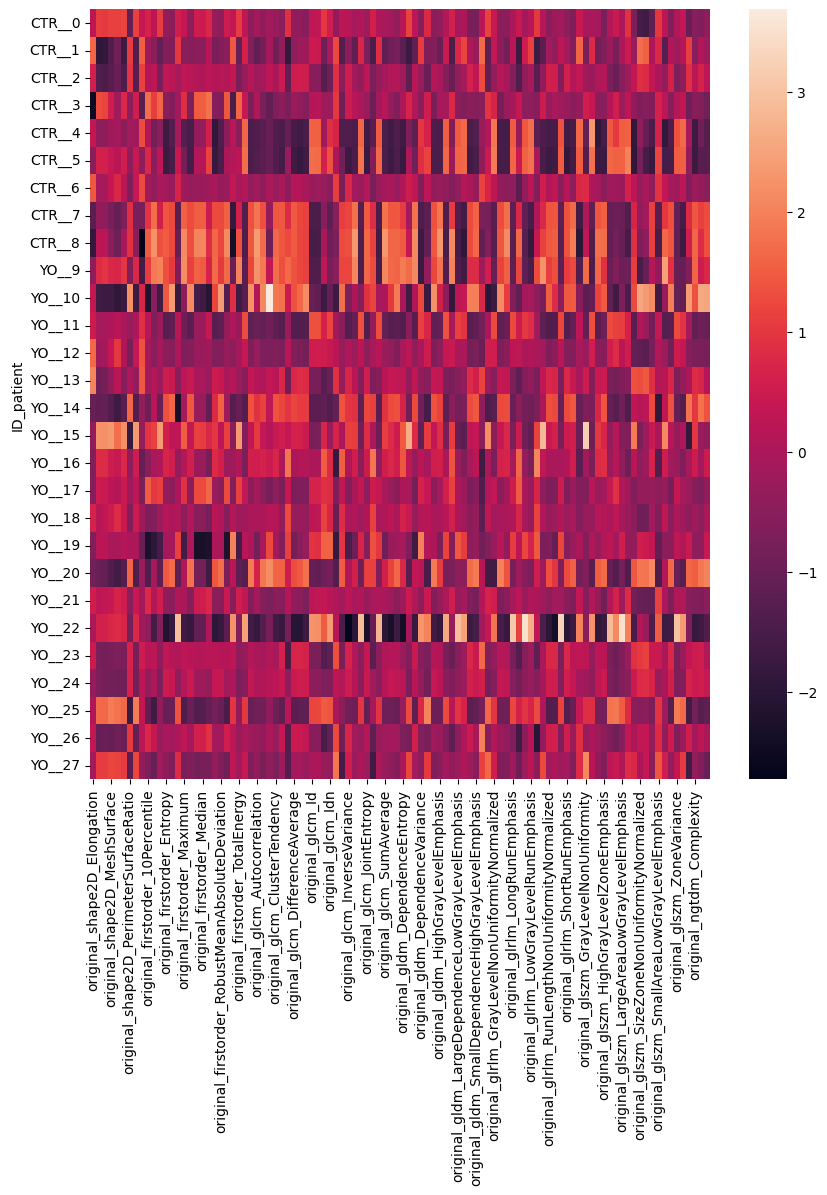

In [34]:
df_tot_means_zscore.set_index('ID_patient',inplace=True)

sns.heatmap(df_tot_means_zscore)

In [35]:
first_order = []
shape_2D = []
glcm = []
gldm = []
glszm = []
glrlm = []
ngtdm = []

first_order_wavelet = []
shape_2D_wavelet = []
glcm_wavelet = []
gldm_wavelet = []
glszm_wavelet = []
glrlm_wavelet = []


clinical = []

for i in list(df_tot_means_zscore.columns) :
    if "wavelet" not in i :
        if "firstorder" in i :
            first_order.append(i)
        elif "shape2D" in i :
            shape_2D.append(i)
        elif "glcm" in i :
            glcm.append(i)
        elif "gldm" in i :
            gldm.append(i)
        elif "glrlm" in i :
            glrlm.append(i)
        elif "glszm" in i :
            glszm.append(i)
        elif "ngtdm" in i :
            ngtdm.append(i)
        else : 
            clinical.append(i)
            

In [36]:
list(df_tot_means_zscore.index)

['CTR__0',
 'CTR__1',
 'CTR__2',
 'CTR__3',
 'CTR__4',
 'CTR__5',
 'CTR__6',
 'CTR__7',
 'CTR__8',
 'YO__9',
 'YO__10',
 'YO__11',
 'YO__12',
 'YO__13',
 'YO__14',
 'YO__15',
 'YO__16',
 'YO__17',
 'YO__18',
 'YO__19',
 'YO__20',
 'YO__21',
 'YO__22',
 'YO__23',
 'YO__24',
 'YO__25',
 'YO__26',
 'YO__27']

In [37]:
Xs_df = list([df_tot_means_zscore[first_order].to_numpy(),df_tot_means_zscore[shape_2D].to_numpy(),df_tot_means_zscore[glcm].to_numpy(),df_tot_means_zscore[gldm].to_numpy(),df_tot_means_zscore[glrlm].to_numpy(),df_tot_means_zscore[glszm].to_numpy(),df_tot_means_zscore[ngtdm].to_numpy()])#,df[clinical].to_numpy()])

In [38]:
Xs_df

[array([[ 0.67212121,  0.21844624,  1.07379244, -0.33481791, -0.47602017,
          0.56935577,  0.359008  , -0.41592597,  0.52788989,  0.46710329,
          0.75480772, -0.27068434, -0.43385826,  0.48529003,  0.31657695,
          1.07379244,  0.29254451, -0.45072881],
        [-0.20814668, -0.51422479, -1.06108142, -0.61253593, -0.64367507,
          1.02696611, -0.52056159, -0.55277597, -0.48064822, -0.51627205,
          0.15826614, -0.7619263 , -0.60670409, -0.50932437,  1.45139078,
         -1.06108142,  0.64634227, -0.58867822],
        [ 0.11461821,  0.27077988, -0.73695513,  0.28415877,  0.19459944,
         -0.07386772,  0.2961816 ,  0.21961704,  0.08750172,  0.07375315,
          0.24348636,  0.15038019,  0.17539611,  0.09715377,  0.32170991,
         -0.73695513, -0.30945513,  0.14287234],
        [ 1.72844266,  1.09503479,  1.58428417, -0.50958892, -0.64367507,
         -0.10187937,  0.86161919, -0.67962684,  1.48040493,  1.51603699,
          1.77745044, -0.55139403, -0.6

In [39]:
test_label = ['CTR', '', '', '', '', '', '', '', '', 'YO', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

In [40]:
PATH_savefig = '/home/user/Pictures/images_article_Ovaires_YO/'

0
1
2
3
4
5
6


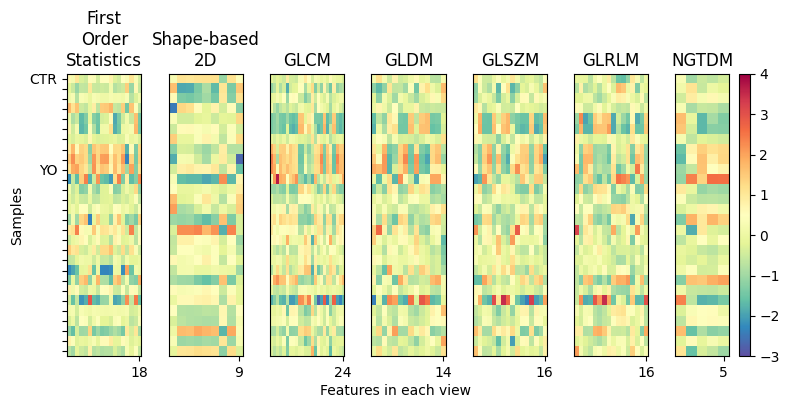

In [44]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
view_names = ['First\nOrder\nStatistics', 'Shape-based\n2D',
              'GLCM', 'GLDM','GLSZM', 'GLRLM','NGTDM']#, 'Clinical\nFeatures']

fig, axes = plt.subplots(1, 7, figsize=(8, 4))
for i, view in enumerate(Xs_df):
    print(i)
    sorted_view = view
  # Scale features in each view to [0, 1]
#     minim = np.min(sorted_view, axis=0)
#     maxim = np.max(sorted_view, axis=0)
#     sorted_view = (sorted_view - minim) / (maxim - minim)#on normalise les données

    pts = axes[i].imshow(
        sorted_view, cmap='Spectral_r', aspect='auto', vmin=-3, vmax=4)

    axes[i].set_title(view_names[i], fontsize=12)
    if i == 0 :
        axes[i].set_yticks(ticks = range(0,28) ,labels = test_label, rotation = 'horizontal')
    else :
        axes[i].set_yticks([])
    max_dim = view.shape[1]
    axes[i].set_xticks([max_dim-1])
    axes[i].set_xticklabels([str(max_dim)])

divider = make_axes_locatable(axes[-1])
cax = divider.append_axes("right", size="20%", pad=0.1)
plt.colorbar(pts, cax=cax)
fig.text(0.5, 0, 'Features in each view', ha='center')
axes[0].set_ylabel('Samples')
plt.tight_layout()
plt.savefig(PATH_savefig+"pyradiomics_values.png")
plt.show()


In [272]:
df_tot_means_zscore.to_csv('df_tot_means_zscore.csv')